In [1]:
# !pip install xgboost
# !pip install shap
# !conda install -c conda-forge shap

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Modele and Explain

In [5]:
base_path = Path('C:\\Users\\beiya.xue\\OneDrive - insidemedia.net\\Python Script\\SERP Work Files\\')
input_file_path = base_path/'Data\\URLData_ZDInterviewProject.csv'

In [6]:
df = pd.read_csv(input_file_path)
df.drop(columns=['URL'], inplace=True)
print(df.dtypes)
print(df.describe())

Google Rank                   float64
# Reviews                     float64
Number of Preview Profiles    float64
Distance                      float64
% Cross Listed Results         object
% Templated Words              object
dtype: object
       Google Rank    # Reviews  Number of Preview Profiles     Distance
count  5000.000000  5000.000000                 5000.000000  5000.000000
mean     13.297700     3.904972                    8.605779     5.002775
std       3.498889     1.001437                    2.007947     0.995558
min       1.000000     0.100000                    2.000000     1.354600
25%      10.900000     3.225434                    7.262847     4.330816
50%      13.300000     3.909821                    8.609062     4.999634
75%      15.600000     4.573138                    9.929759     5.676147
max      25.800000     7.935229                   15.845685     8.713590


In [7]:
# Convert the data types to make it suitable for modeling.
for i in df.columns:
    if df[i].dtype != float:
        df[i] = df[i].str.rstrip('%').astype('float') / 100.0
print(df.dtypes)
df.describe()

Google Rank                   float64
# Reviews                     float64
Number of Preview Profiles    float64
Distance                      float64
% Cross Listed Results        float64
% Templated Words             float64
dtype: object


,Google Rank,# Reviews,Number of Preview Profiles,Distance,% Cross Listed Results,% Templated Words
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,13.297700,3.904972,8.605779,5.002775,0.463535,0.151566
std,3.498889,1.001437,2.007947,0.995558,0.100140,0.085807
min,1.000000,0.100000,2.000000,1.354600,0.100000,0.000000
25%,10.900000,3.225434,7.262847,4.330816,0.396000,0.078000
50%,13.300000,3.909821,8.609062,4.999634,0.466000,0.153000
75%,15.600000,4.573138,9.929759,5.676147,0.533000,0.225250
max,25.800000,7.935229,15.845685,8.713590,0.769000,0.300000


In [8]:
X = df.drop(columns=['Google Rank'])
y = df['Google Rank']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = xgb.XGBRegressor(max_depth=2)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
# Evaluate model performance
model.score(X_train, y_train)

0.9197421487681658

In [10]:
# Evaluate model performance
model.score(X_test, y_test)

0.8992915695518487

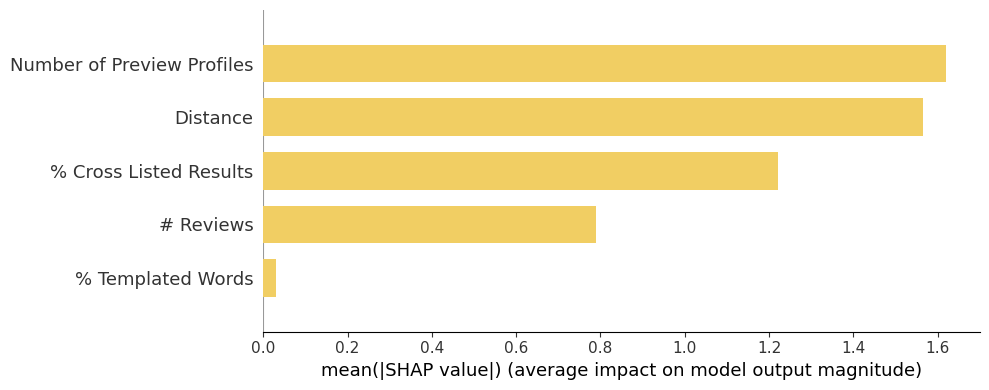

Base Value (Average Prediction): 13.303314


In [33]:
# Create a TreeExplainer object for XGBoost
explainer = shap.TreeExplainer(model)

# Use SHAP to calculate the Shapley values for the test data
shap_values = explainer.shap_values(X_test)
explanation = explainer(X_test)
# Visualize the global feature importance
shap.summary_plot(shap_values, feature_names=X_test.columns, plot_type="bar", plot_size=[10,4], color="#f1ce63")

# Get the base value (average predicted value)
base_value = explainer.expected_value
print("Base Value (Average Prediction):", base_value)

In [ ]:
pd.DataFrame(data=[abs(shap_values).mean(axis=0)], columns=X_test.columns)

,# Reviews,Number of Preview Profiles,Distance,% Cross Listed Results,% Templated Words
0,0.790073,1.619354,1.565761,1.221158,0.029933


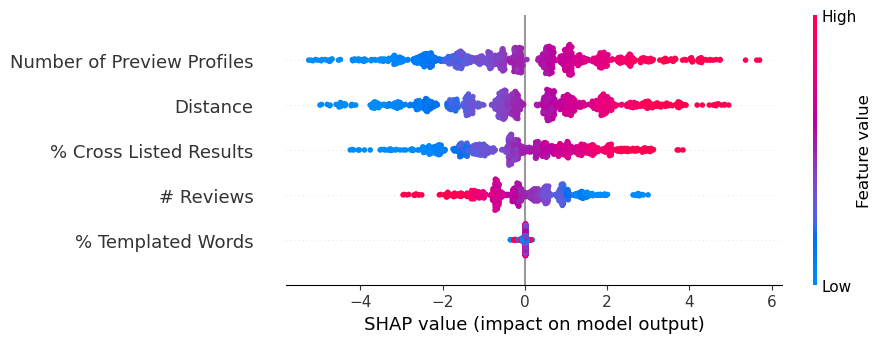

In [12]:
# Each point on the plot represents a SHAP value for a particular feature and a specific instance (observation) in the dataset.
shap.plots.beeswarm(explainer(X_test))

In [ ]:
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)
shap_values_df.mean()

# Reviews                     0.003358
Number of Preview Profiles   -0.085200
Distance                      0.008725
% Cross Listed Results        0.011402
% Templated Words             0.002409
dtype: float32

# Calculate Sample Size

In [66]:
import math

# Parameters
Z_alpha_2 = 1.96  # Z-score for 5% significance level
Z_beta = 0.84     # Z-score for 80% power
p1 = 0.23         # Baseline conversion rate (control group)
p2 = 0.28         # Expected conversion rate in treatment group (control group + effect size)

# Calculate sample size for each group
numerator = (Z_alpha_2 + Z_beta) ** 2 * (p1 * (1 - p1) + p2 * (1 - p2))
denominator = (p1 - p2) ** 2
sample_size_per_group = numerator / denominator

sample_size_per_group

1187.603199999999

# Calculate Experiment Duration

In [67]:
round(sample_size_per_group)*2/1000

2.376